# Proyecto

Decidimos elegir un problema muy conocido, aunque todavía relativamente pequeño: el conjunto de datos de la flor Iris. Este conjunto de datos incluso tiene su propia página en Wikipedia. Aunque el conjunto de datos Iris es bien conocido por los científicos de datos, lo presentaremos brevemente para refrescar la memoria. Para hacer una comparación, primero entrenaremos un modelo clásico como contraparte del modelo cuántico.

## Análisis de Datos

In [1]:
# %pip install scikit-learn seaborn qiskit_machine_learning pylatexenc qiskit_ionq

In [2]:
from sklearn.datasets import load_iris
iris_data = load_iris()

Si no se especifican parámetros en la función `load_iris`, entonces Scikit-learn devuelve un objeto similar a un diccionario. Imprimamos la descripción del conjunto de datos para ver qué contiene.

In [3]:
print(iris_data.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

:Number of Instances: 150 (50 in each of three classes)
:Number of Attributes: 4 numeric, predictive attributes and the class
:Attribute Information:
    - sepal length in cm
    - sepal width in cm
    - petal length in cm
    - petal width in cm
    - class:
            - Iris-Setosa
            - Iris-Versicolour
            - Iris-Virginica

:Summary Statistics:

============== ==== ==== ======= ===== ====================
                Min  Max   Mean    SD   Class Correlation
============== ==== ==== ======= ===== ====================
sepal length:   4.3  7.9   5.84   0.83    0.7826
sepal width:    2.0  4.4   3.05   0.43   -0.4194
petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
============== ==== ==== ======= ===== ====================

:Missing Attribute Values: None
:Class Distribution: 33.3% for each of 3 classes.
:Cr

* Hay 150 muestras (instancias) en el conjunto de datos.
* Cada muestra tiene cuatro características (atributos).
* Hay tres etiquetas (clases) en el conjunto de datos.
* El conjunto de datos está perfectamente equilibrado, ya que hay el mismo número de muestras (50) en cada clase.
* Podemos observar que las características no están normalizadas y que sus rangos de valores son diferentes. Por ejemplo, la longitud del sépalo y el ancho del pétalo tienen diferentes escalas. Por lo tanto, transformar las características a la misma escala podría ser útil.
* Como se indicó en la tabla anterior, la correlación entre algunas características y las clases es muy alta. Esto puede llevarnos a pensar que nuestro modelo debería manejar bien el conjunto de datos.

In [4]:
features = iris_data.data
labels = iris_data.target

Primero, normalizaremos las características. Es decir, aplicaremos una transformación simple para representar todas las características en la misma escala. En nuestro caso, comprimimos todas las características en el intervalo $[0,1]$.

In [5]:
from sklearn.preprocessing import MinMaxScaler

features = MinMaxScaler().fit_transform(features)

Veamos cómo se ven nuestros datos. Graficamos las características de forma pareada para observar si hay una correlación observable entre ellas.

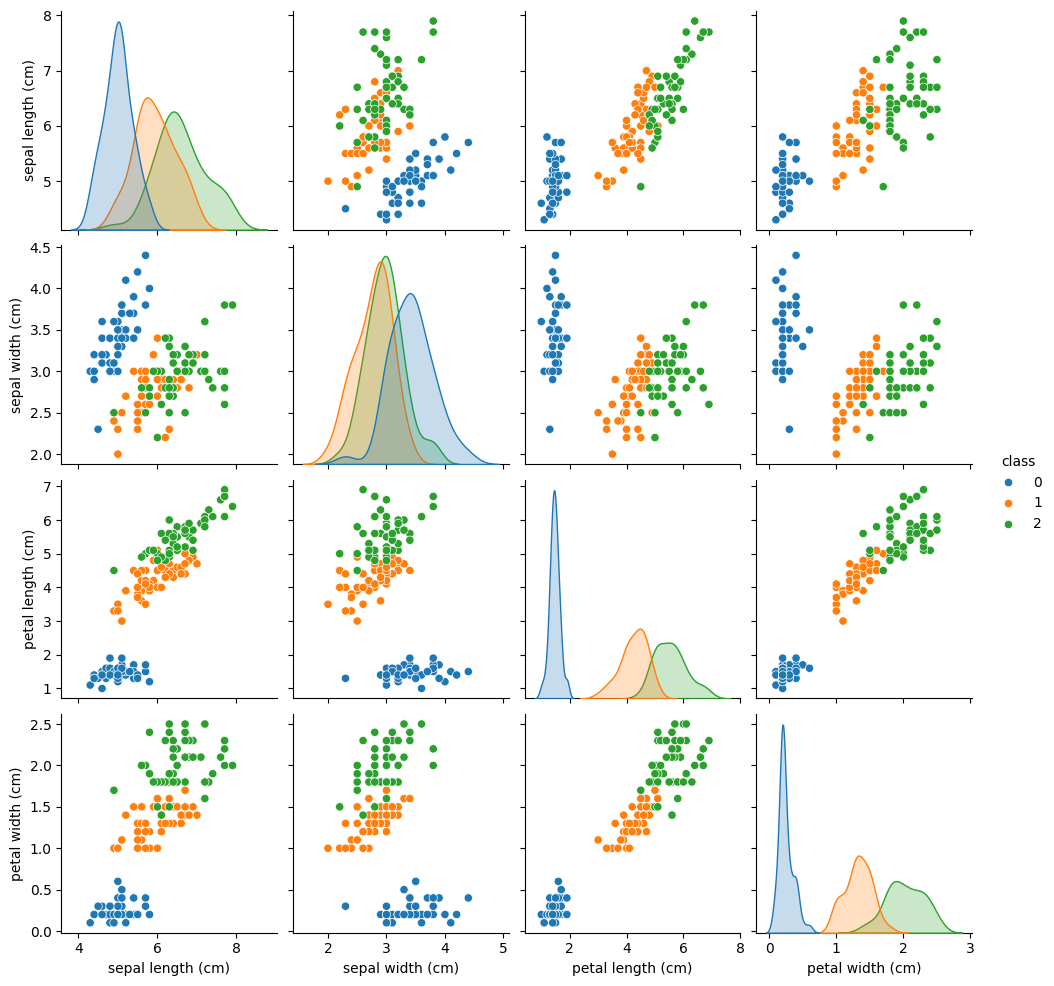

In [6]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame(iris_data.data, columns=iris_data.feature_names)
df["class"] = pd.Series(iris_data.target)

sns.pairplot(df, hue="class", palette="tab10")

Separar los datos entre entrenamiento y test

In [7]:
from sklearn.model_selection import train_test_split
from qiskit_machine_learning.utils import algorithm_globals

algorithm_globals.random_seed = 123
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, train_size=0.8, random_state=algorithm_globals.random_seed
)

# Ejercicio 1

### Mapa de Caracteristicas

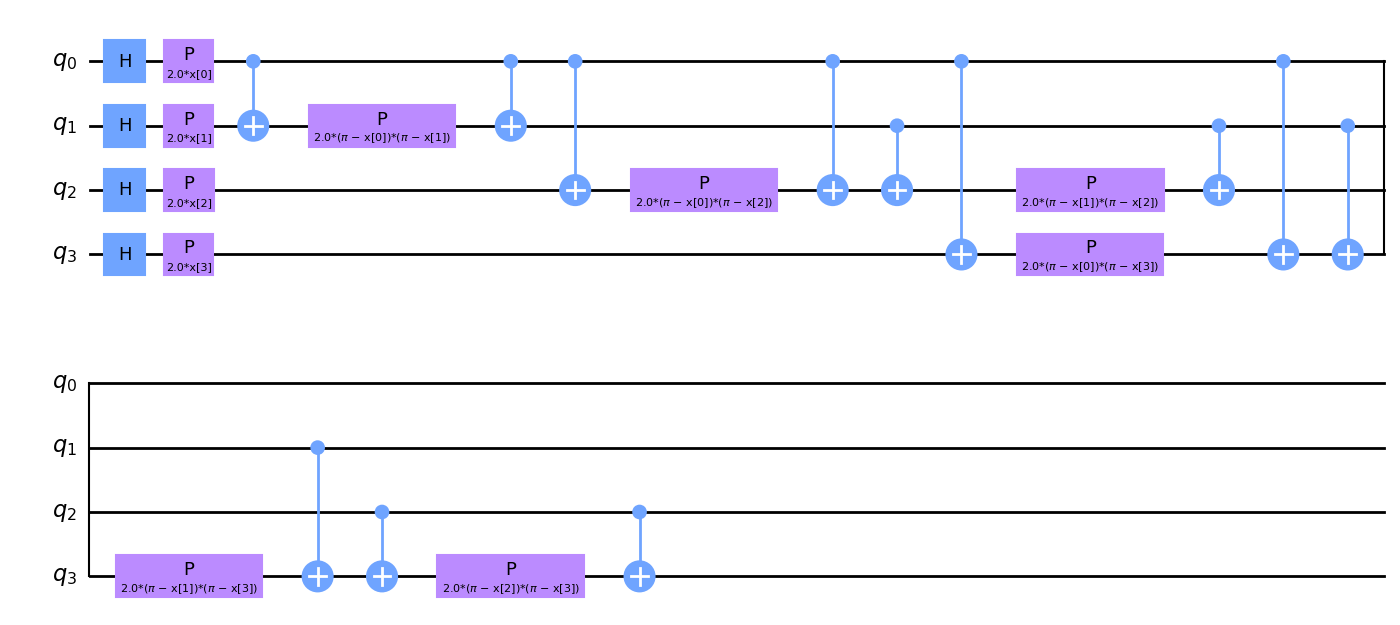

In [8]:
from qiskit.circuit.library import ZZFeatureMap

num_features = features.shape[1]

feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
feature_map.decompose().draw(output="mpl", style="clifford", fold=20)

### Algoritmo Variacional

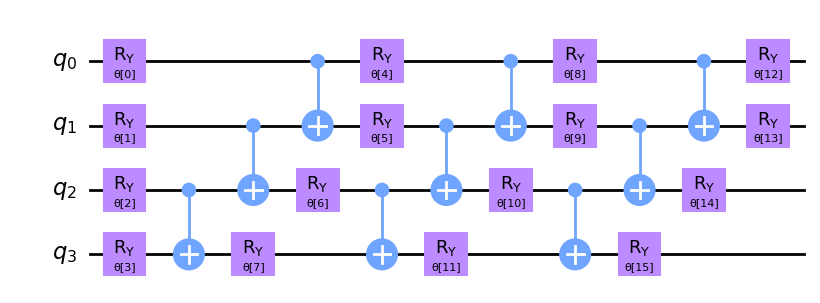

In [9]:
from qiskit.circuit.library import RealAmplitudes

ansatz = RealAmplitudes(num_qubits=num_features, reps=3)
ansatz.decompose().draw(output="mpl", style="clifford", fold=20)

### Optimizador

In [10]:
from qiskit_machine_learning.optimizers import COBYLA
from qiskit.primitives import StatevectorSampler as Sampler
from matplotlib import pyplot as plt
from IPython.display import clear_output
import time
from qiskit_machine_learning.algorithms.classifiers import VQC

optimizer = COBYLA(maxiter=100)
sampler = Sampler()
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)


def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [11]:
vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.


### Entrenar el Algoritmo

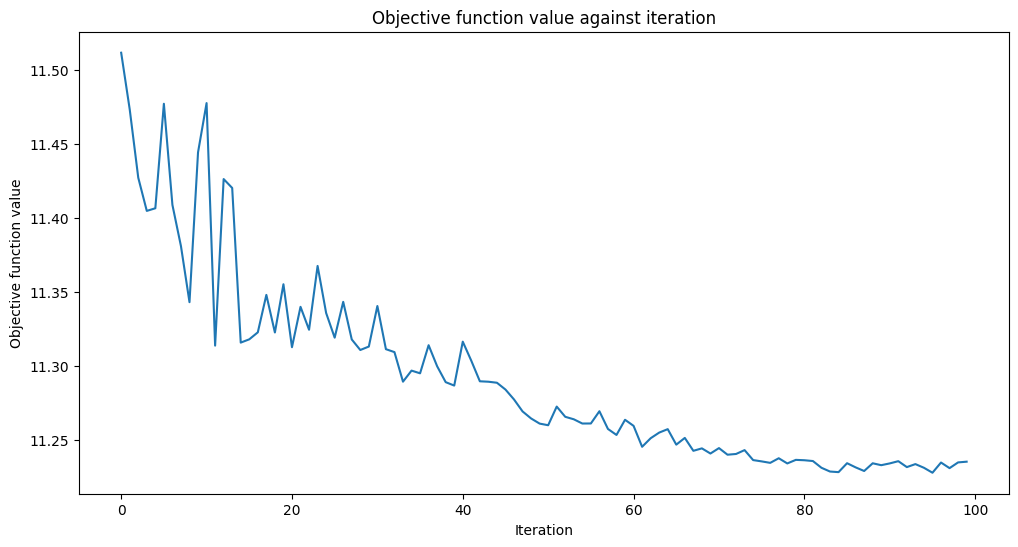

Training time: 110 seconds


In [12]:
# clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(train_features, train_labels)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

### Evaluar el entrenamiento

In [13]:
train_score_q4 = vqc.score(train_features, train_labels)
test_score_q4 = vqc.score(test_features, test_labels)

print(f"Quantum VQC on the training dataset: {train_score_q4:.2f}")
print(f"Quantum VQC on the test dataset:     {test_score_q4:.2f}")

Quantum VQC on the training dataset: 0.62
Quantum VQC on the test dataset:     0.60


### Utilizando otro mapa de caractersiticas

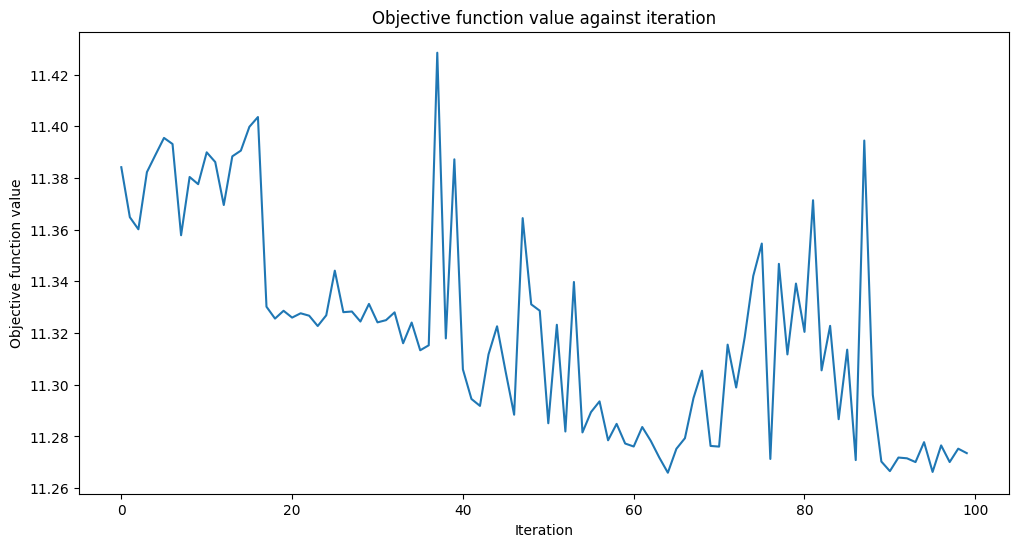

Training time: 126 seconds


In [14]:
from qiskit.circuit.library import EfficientSU2

ansatz = EfficientSU2(num_qubits=num_features, reps=3)
optimizer = COBYLA(maxiter=100)

vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(train_features, train_labels)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [15]:
train_score_q2_eff = vqc.score(train_features, train_labels)
test_score_q2_eff = vqc.score(test_features, test_labels)

print(f"Quantum VQC on the training dataset using EfficientSU2: {train_score_q2_eff:.2f}")
print(f"Quantum VQC on the test dataset using EfficientSU2:     {test_score_q2_eff:.2f}")

Quantum VQC on the training dataset using EfficientSU2: 0.60
Quantum VQC on the test dataset using EfficientSU2:     0.40


# Ejercicio 2 - Reducir numero de Caractersiticas

Evaluar el Ejercicio anterior usando solo dos caracteristicas

<Axes: >

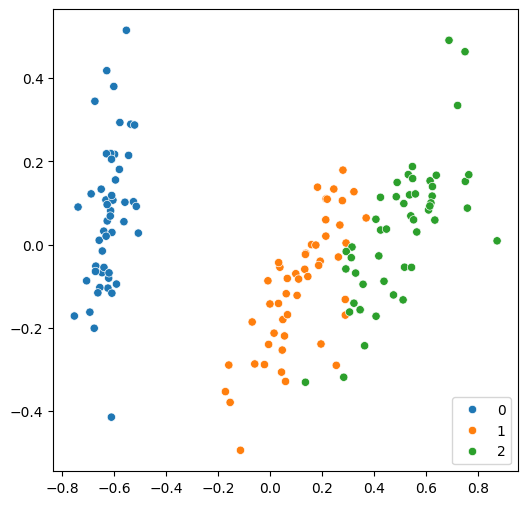

In [16]:
from sklearn.decomposition import PCA

features = PCA(n_components=2).fit_transform(features)

plt.rcParams["figure.figsize"] = (6, 6)
sns.scatterplot(x=features[:, 0], y=features[:, 1], hue=labels, palette="tab10")

### Definir el conjunto de entrenamiento y test

In [17]:
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, train_size=0.8, random_state=algorithm_globals.random_seed
)

### Generar el mapa de caracteristicas 

In [18]:
num_features = features.shape[1]
feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)

### Generar Algoritmo Variacional

In [19]:
ansatz = RealAmplitudes(num_qubits=num_features, reps=3)

### Optimizar el algoritmo

In [20]:
vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.


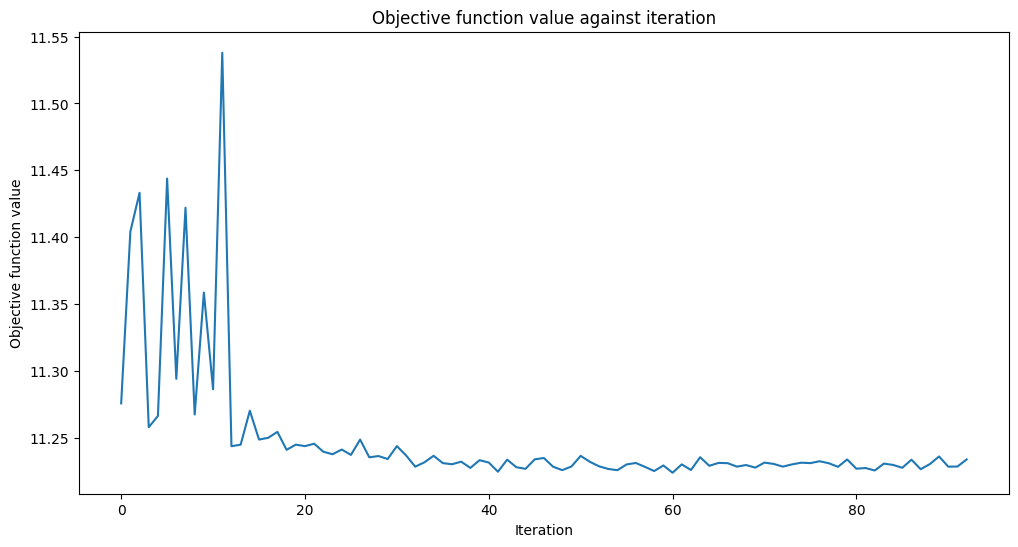

Training time: 76 seconds


In [21]:
# clear objective value history
objective_func_vals = []

# make the objective function plot look nicer.
plt.rcParams["figure.figsize"] = (12, 6)


start = time.time()
vqc.fit(train_features, train_labels)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

### Evaluar el Algoritmo

In [22]:
train_score_q2_ra = vqc.score(train_features, train_labels)
test_score_q2_ra = vqc.score(test_features, test_labels)

print(f"Quantum VQC on the training dataset using RealAmplitudes: {train_score_q2_ra:.2f}")
print(f"Quantum VQC on the test dataset using RealAmplitudes:     {test_score_q2_ra:.2f}")

Quantum VQC on the training dataset using RealAmplitudes: 0.53
Quantum VQC on the test dataset using RealAmplitudes:     0.37


### Utilizando otro Mapa de Caracteristicas

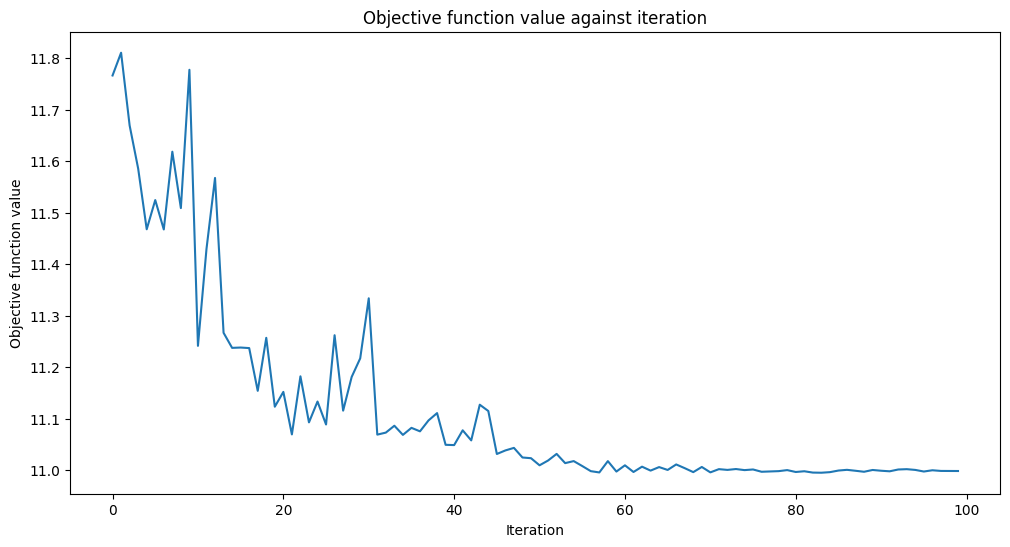

Training time: 89 seconds


In [23]:
from qiskit.circuit.library import EfficientSU2

ansatz = EfficientSU2(num_qubits=num_features, reps=3)
optimizer = COBYLA(maxiter=100)

vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(train_features, train_labels)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [24]:
train_score_q2_eff = vqc.score(train_features, train_labels)
test_score_q2_eff = vqc.score(test_features, test_labels)

print(f"Quantum VQC on the training dataset using EfficientSU2: {train_score_q2_eff:.2f}")
print(f"Quantum VQC on the test dataset using EfficientSU2:     {test_score_q2_eff:.2f}")

Quantum VQC on the training dataset using EfficientSU2: 0.67
Quantum VQC on the test dataset using EfficientSU2:     0.63


## Correr IonQ

In [1]:
# !pip install qiskit_ionq qiskit_ibm_runtime scikit-learn pandas qiskit_machine_learning matplotlib pylatexenc

In [2]:
# %pip install scikit-learn pandas qiskit_machine_learning matplotlib pylatexenc
# %pip install pennylane
# %pip install pennylane-qiskit

In [3]:
from qiskit_ibm_runtime import SamplerV2 as Sampler
# Packages for synthetic data generation and pre-processing.  
from sklearn.datasets import make_blobs, make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import pandas as pd

# Qiskit packages
from qiskit.circuit.library import ZZFeatureMap,RealAmplitudes
from qiskit.primitives import StatevectorSampler
from qiskit_machine_learning.optimizers import SPSA
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# Packages for data visualization
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

import warnings
warnings.filterwarnings('ignore')


In [4]:
# X, y = make_moons(n_samples=100, noise=0.1, random_state=42)
X, y = make_blobs(n_samples=100, centers=2, n_features=4, cluster_std=0.1, random_state=42)

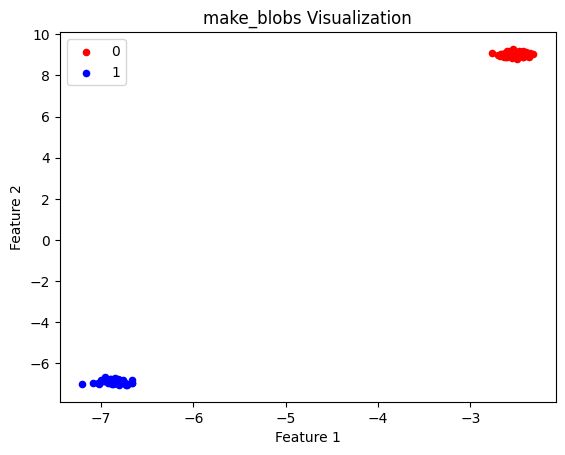

In [5]:
# Create a Pandas DataFrame for easier plotting
df = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=y))

colors = {0:'red', 1:'blue'}
fig, ax = plt.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])

plt.title('make_blobs Visualization')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

In [6]:
train_data, test_data, train_labels, test_labels = train_test_split(X, y, test_size=0.04, random_state=24)

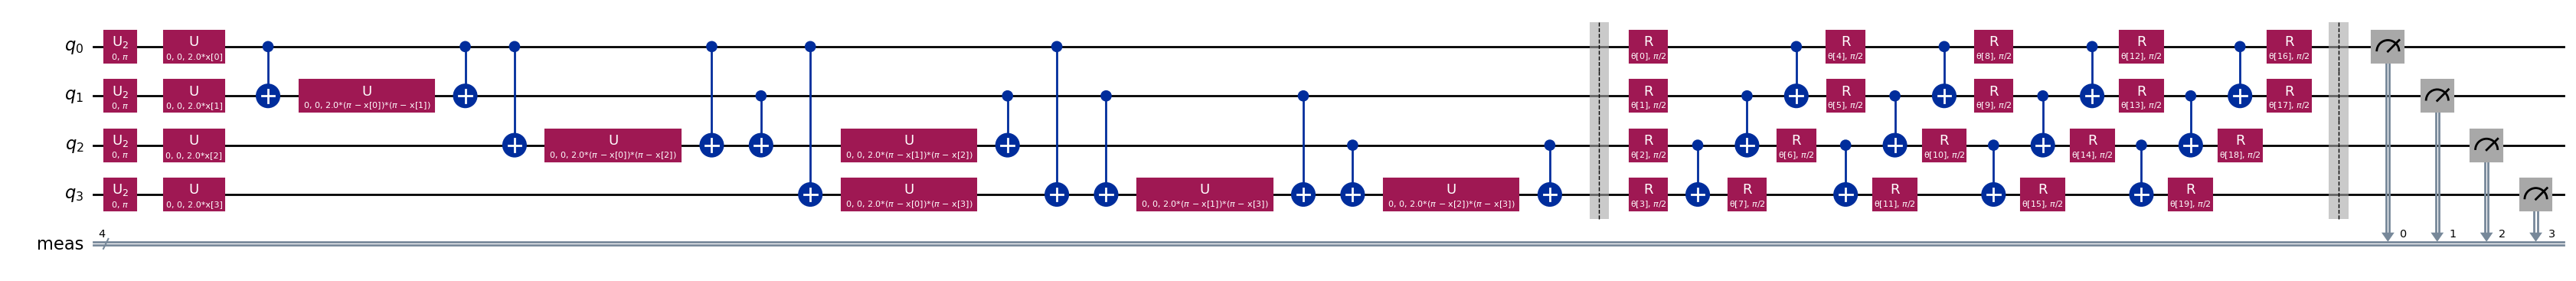

In [7]:
feature_map = ZZFeatureMap(feature_dimension=4, reps=1)
feature_map.barrier()
var_form = RealAmplitudes(num_qubits=4, reps=4)
circuit = feature_map.compose(var_form).decompose()
circuit.measure_all()
circuit.decompose().draw(output="mpl", fold=-1, style="iqp")


In [8]:
def circuit_instance(data, variational):
    """
    Assigns parameter values to the quantum circuit.
    """
    parameters = {}
    for i, p in enumerate(feature_map.parameters):
        parameters[p] = data[i]
    for i, p in enumerate(var_form.ordered_parameters):
        parameters[p] = variational[i]
    return circuit.assign_parameters(parameters)

In [9]:
def labels_probability(results):
    """
    Converts a dictionary of bitstrings and their counts, to parities and their counts
    """
    shots = sum(results.values())
    probabilities = {0: 0, 1: 0}
    for bitstring, counts in results.items():
        label = (sum(int(k) for k in list(bitstring))+1) % 2
        probabilities[label] += counts / shots
    return probabilities

In [10]:
from qiskit_braket_provider import BraketLocalBackend, BraketProvider, to_braket
from braket.aws import AwsDevice
local_simulator = BraketLocalBackend()

In [11]:
def classification_probability_simulation(data, variational):
    """
    Classify data points using given parameters.
    """
    circuits = [circuit_instance(d, variational) for d in data]
    sampler = StatevectorSampler()
    results = []
    for qc in circuits:
        results.append(local_simulator.run(qc))
    # print(results[1].data.meas.get_counts())
    classification = [labels_probability(results[i].result().get_counts()) for i in range(len(results))]
    return classification

In [12]:
def cross_entropy_loss(classification, expected):
    """
    Calculate accuracy of predictions using cross entropy loss.
    """
    p = classification.get(expected)  
    return -np.log(p + 1e-10)

In [13]:
def cost_function(data, labels, variational):
    """
    Evaluates performance of our circuit with variational parameters on data.
    """
    classifications = classification_probability_simulation(data, variational)
    cost = 0
    for i, classification in enumerate(classifications):
        cost += cross_entropy_loss(classification, labels[i])
    cost /= len(data)
    return cost


In [14]:
def objective_function(variational):
    """Cost function of circuit parameters on training data.
    The optimizer will attempt to minimize this."""
    return cost_function(train_data, train_labels, variational)


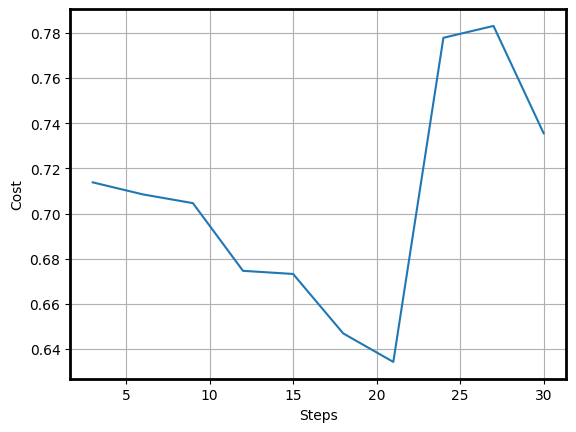

In [15]:
class OptimizerLog:
    """Log to store optimizer's intermediate results"""
    def __init__(self):
        self.evaluations = []
        self.parameters = []
        self.costs = []
    def update(self, evaluation, parameter, cost, _stepsize, _accept):
        """Save intermediate results. Optimizer passes five values
        but we ignore the last two."""
        self.evaluations.append(evaluation)
        self.parameters.append(parameter)
        self.costs.append(cost)
             
# Set up the optimization
log = OptimizerLog()
optimizer = SPSA(maxiter=10, callback=log.update)

initial_point = np.zeros((var_form.num_parameters))

# Run the optimization
result = optimizer.minimize(objective_function, initial_point)

opt_var = result.x
opt_value = result.fun

fig = plt.figure()
plt.plot(log.evaluations, log.costs)
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.grid(True)
plt.rc('axes', linewidth=2)  # Set the axes linewidth globally
ax = plt.gca()  # Get current axes
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
plt.show()

# Model Test

In [16]:
def create_conf_mat(y_true, y_pred, title):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Normalize the confusion matrix by row (i.e., by the number of samples in each class)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    # Create a custom colormap
    colors = [(1, 1, 1), (0/255, 255/255, 0/255)] 
    n_bins = 100  # Number of bins in the colormap
    cmap_name = 'custom_blue'
    custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

    # Display confusion matrix
    fig, ax = plt.subplots()
    cax = ax.matshow(cm_normalized, cmap=custom_cmap)

    # Add color bar
    fig.colorbar(cax)

    # Set predefined RGB color for the text
    for i in range(cm_normalized.shape[0]):
        for j in range(cm_normalized.shape[1]):
            color = 'white' if i == j else 'black'
            ax.text(j, i, f'{cm_normalized[i, j]:.1f}%', va='center', ha='center', color=color)

    # Set predefined background color for the diagonal elements (e.g., RGB (255, 255, 0))
    diagonal_color = (98/255, 35/255, 223/255)  # Normalize to 0-1 range
    for i in range(cm_normalized.shape[0]):
        ax.add_patch(plt.Rectangle((i-0.5, i-0.5), 1, 1, fill=True, color=diagonal_color, alpha=0.3))

    # Set predefined background color for the plot (e.g., RGB (240, 240, 240))
    background_color = (1, 1, 1)  # Normalize to 0-1 range
    fig.patch.set_facecolor(background_color)
    ax.set_facecolor(background_color)

    plt.title(title)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

In [17]:
def classification_probability_qiskit(data, variational):
    """
    Classify data points using given parameters.
    """
    circuits = [circuit_instance(d, variational) for d in data]
    isa_circuit = pm.run(circuits)
    results = sampler.run(isa_circuit, shots=1024).result()
    classification = [
        labels_probability(i['__value__']['data'].meas.get_counts()) for i in results]
    return classification

In [18]:
 # !qbraid jobs enable braket --yes

In [19]:
# !pip install qbraid

In [21]:
from qiskit import transpile

provider = BraketProvider()
# device = AwsDevice("arn:aws:braket:us-east-1::device/qpu/ionq/Forte-1")
# device = local_simulator

In [22]:
provider.backends()

[BraketBackend[Ankaa-3],
 BraketBackend[Aria 1],
 BraketBackend[Aria 2],
 BraketBackend[Forte 1],
 BraketBackend[Garnet],
 BraketBackend[SV1],
 BraketBackend[TN1],
 BraketBackend[dm1]]

In [23]:
backend = BraketProvider().get_backend("Forte 1")

In [26]:
def classification_probability_real(data, variational):
    """
    Classify data points using given parameters.
    """
    circuits = [circuit_instance(d, variational) for d in data]
    sampler = StatevectorSampler()
    results = []
    for qc in circuits:
        results.append(backend.run(qc,shots=1000))
    # print(results[1].data.meas.get_counts())
    classification = [labels_probability(results[i].result().get_counts()) for i in range(len(results))]
    return classification

In [29]:
def test_classifier(data, labels, variational):
    """
    Gets classifier'spredictions and calculates accuracy 
    """
    probability = classification_probability_real(data, variational)
    predictions = [0 if p[0] >= p[1] else 1 for p in probability]
    accuracy = 0
    for i, prediction in enumerate(predictions):
        if prediction == labels[i]:
            accuracy += 1
    accuracy /= len(labels)
    print(f"Qiskit Test Accuracy: {accuracy * 100:.2f}%")
    # create_conf_mat(labels, predictions, "Qiskit Evaluation")
    return accuracy, predictions

accuracy_qiskit, predictions_qiskit = test_classifier([test_data[0]], [test_labels[0]], opt_var)

ERROR:backoff:Giving up get_quantum_task(...) after 1 tries (botocore.exceptions.ClientError: An error occurred (500) when calling the GetQuantumTask operation (reached max retries: 4): )


ClientError: An error occurred (500) when calling the GetQuantumTask operation (reached max retries: 4): 